In [11]:
import pandas as pd
import numpy as np

# Load your cleaned dataset (same one you used before)
df = pd.read_csv("merged_applicant_and_bureau_cleaned.csv")

print("Shape:", df.shape)
print("Columns:", df.columns.tolist()[:20])
df.head()


Shape: (152889, 28)
Columns: ['SK_ID_CURR', 'TARGET', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED', 'OCCUPATION_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'AGE', 'AMT_CREDIT_SUM_sum', 'AMT_CREDIT_SUM_DEBT_sum', 'AMT_CREDIT_SUM_OVERDUE_max', 'CREDIT_DAY_OVERDUE_max', 'CNT_CREDIT_PROLONG_sum', 'CREDIT_ACTIVE_Active']


,SK_ID_CURR,TARGET,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_EMPLOYED,...,CNT_CREDIT_PROLONG_sum,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Closed,CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Microloan,CREDIT_TYPE_Unknown type of loan,CREDIT_TYPE_Another type of loan,DEBT_RATIO,OVERDUE_RATIO
0,100003,0,State servant,Married,0,270000.0,1293502.5,35698.5,1129500.0,-1188.0,...,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100009,0,Commercial associate,Married,1,171000.0,1560726.0,41301.0,1395000.0,-3130.0,...,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100011,0,Pensioner,Married,0,112500.0,1019610.0,33826.5,913500.0,NaN,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,100016,0,Working,Married,0,67500.0,80865.0,5881.5,67500.0,-2717.0,...,0.0,1.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0
4,100017,0,Working,Married,1,225000.0,918468.0,28966.5,697500.0,-3028.0,...,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


Top 15 IV variables: ['DAYS_EMPLOYED', 'DEBT_RATIO', 'AMT_CREDIT_SUM_DEBT_sum', 'OCCUPATION_TYPE', 'AGE', 'CREDIT_ACTIVE_Active', 'NAME_INCOME_TYPE', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'CREDIT_ACTIVE_Closed', 'NAME_FAMILY_STATUS', 'CREDIT_TYPE_Credit card', 'FLAG_OWN_CAR', 'CREDIT_TYPE_Microloan']
Numeric columns used for correlation: ['DAYS_EMPLOYED', 'DEBT_RATIO', 'AMT_CREDIT_SUM_DEBT_sum', 'AGE', 'CREDIT_ACTIVE_Active', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'CREDIT_ACTIVE_Closed', 'CREDIT_TYPE_Credit card', 'CREDIT_TYPE_Microloan']


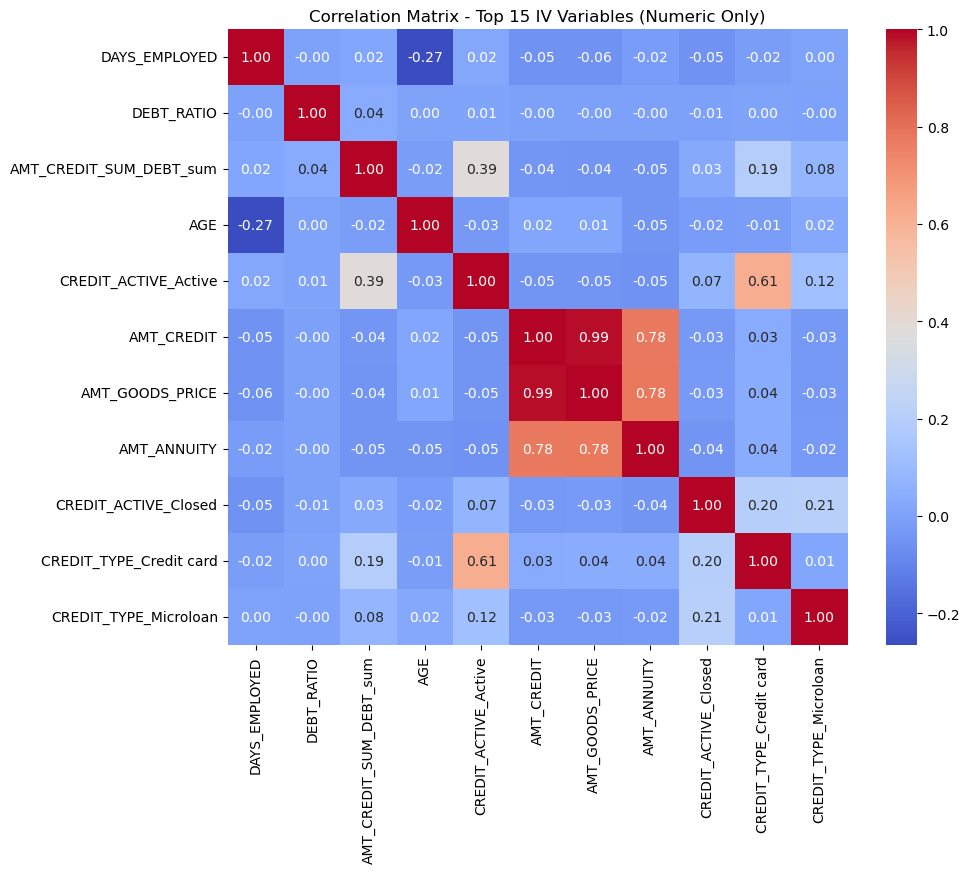

In [12]:
top15_vars = iv_df.sort_values('IV', ascending=False)['variable'].head(15).tolist()
print("Top 15 IV variables:", top15_vars)

numeric_cols = df[top15_vars].select_dtypes(include=['number']).columns.tolist()
print("Numeric columns used for correlation:", numeric_cols)

corr_matrix = df[numeric_cols].corr()

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix - Top 15 IV Variables (Numeric Only)")
plt.show()


AMT_CREDIT, AMT_GOODS_PRICE, and AMT_ANNUITY are very highly correlated (r ≈ 0.99 and 0.78).

These variables all represent the loan size, so including all of them would cause multicollinearity and make the logistic regression unstable.

To simplify the model and improve interpretability:

Kept: AMT_CREDIT (clear, representative feature)

Dropped: AMT_GOODS_PRICE, AMT_ANNUITY

This keeps the model cleaner while retaining the same predictive power.

In [13]:
# DROP redundant variables, keep one representative 

import os


# 1) Load data safely (read-only mindset)
MASTER_PATH = "merged_applicant_and_bureau_cleaned.csv"      
IV_PATH     = "woe_iv_outputs/woe_iv_summary.csv"            
OUT_DIR     = "model_data"                              

os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(MASTER_PATH)
iv_df = pd.read_csv(IV_PATH)

print("Loaded:", MASTER_PATH, "Shape:", df.shape)
print("Loaded IV table:", IV_PATH, "Top rows:")
display(iv_df.head(10))

# sanity: check the 3 variables are present
cols_expected = {"AMT_CREDIT", "AMT_GOODS_PRICE", "AMT_ANNUITY"}
missing = [c for c in cols_expected if c not in df.columns]
if missing:
    print("⚠️ Missing in dataset:", missing, "— skipping those from drop list.")

# Decide redundant variables to drop based on your correlation findings
#    Keep AMT_CREDIT (representative); drop the others if present.
drop_redundant = [c for c in ["AMT_GOODS_PRICE", "AMT_ANNUITY"] if c in df.columns]


df_model_ready = df.copy()

#  Drop the redundant columns
df_model_ready.drop(columns=drop_redundant, inplace=True, errors="ignore")


# Save the new, safe file
OUT_CSV = os.path.join(OUT_DIR, "eldercare_model_ready_dropcorr.csv")
df_model_ready.to_csv(OUT_CSV, index=False)

print(" Saved model-ready copy to:", OUT_CSV)
print("New shape:", df_model_ready.shape)


#  quick check the kept/dropped columns around loan size
kept_cols = [c for c in df_model_ready.columns if c.startswith("AMT_")]
print("Amount-like columns now:", kept_cols)


Loaded: merged_applicant_and_bureau_cleaned.csv Shape: (152889, 28)
Loaded IV table: woe_iv_outputs/woe_iv_summary.csv Top rows:


,variable,IV
0,DAYS_EMPLOYED,0.091306
1,DEBT_RATIO,0.077947
2,AMT_CREDIT_SUM_DEBT_sum,0.076850
3,OCCUPATION_TYPE,0.067540
4,AGE,0.054176
5,CREDIT_ACTIVE_Active,0.045366
6,NAME_INCOME_TYPE,0.039106
7,AMT_CREDIT,0.037432
8,AMT_GOODS_PRICE,0.031239
9,AMT_ANNUITY,0.025038


 Saved model-ready copy to: model_data/eldercare_model_ready_dropcorr.csv
New shape: (152889, 26)
Amount-like columns now: ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_CREDIT_SUM_sum', 'AMT_CREDIT_SUM_DEBT_sum', 'AMT_CREDIT_SUM_OVERDUE_max']


kept AMT_CREDIT and dropped AMT_GOODS_PRICE and AMT_ANNUITY because they’re highly correlated (r ≈ 0.99 and 0.78). This avoids multicollinearity and keeps the scorecard simpler. The new file is model_data/eldercare_model_ready_dropcorr.csv